In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
import sys 
sys.path.append('./models')
from Arima import ARIMA_Model


C:\Users\grego\AppData\Local\Temp\ipykernel_20292\2231974440.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('deaths_and_infections.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
new_deaths=np.array(df['new_deaths'])
death_cumul=np.array([sum(new_deaths[:i]) for i in range(len(new_deaths))])
dates_of_pandemic=np.arange(len(new_deaths))

Test of a single ARIMA model 

c:\Users\grego\Miniconda3\envs\env_qcm\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\grego\Miniconda3\envs\env_qcm\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


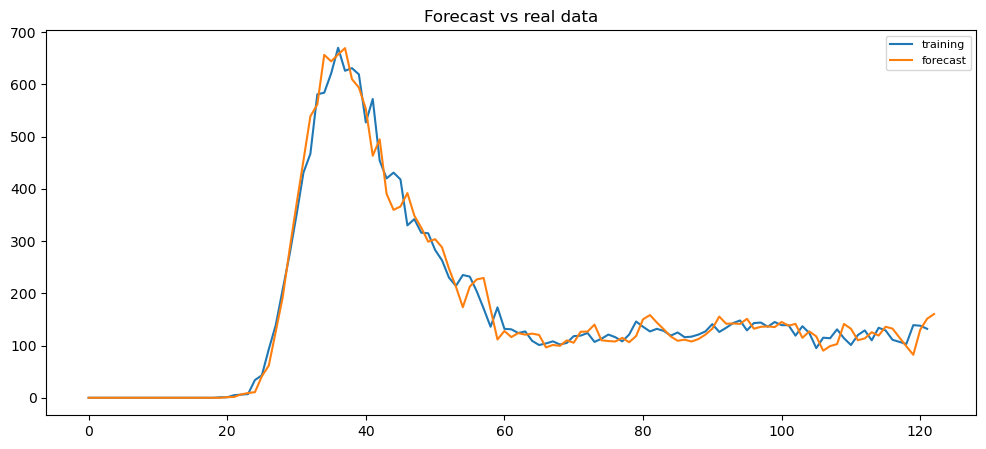

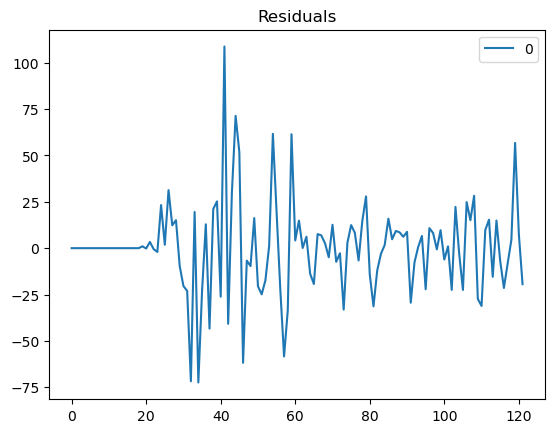

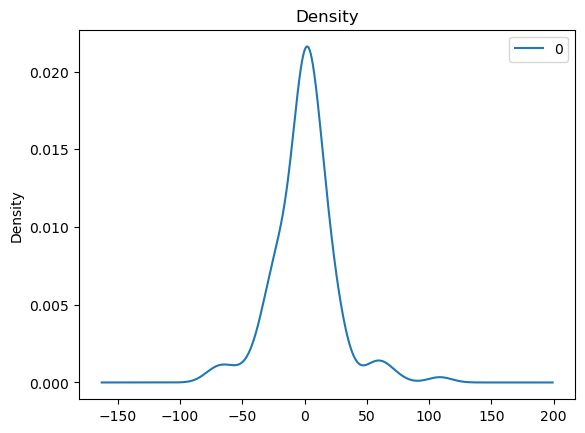

                0
count  122.000000
mean     0.157880
std     25.037464
min    -72.381901
25%     -9.647506
50%      0.000000
75%      9.761334
max    108.687034


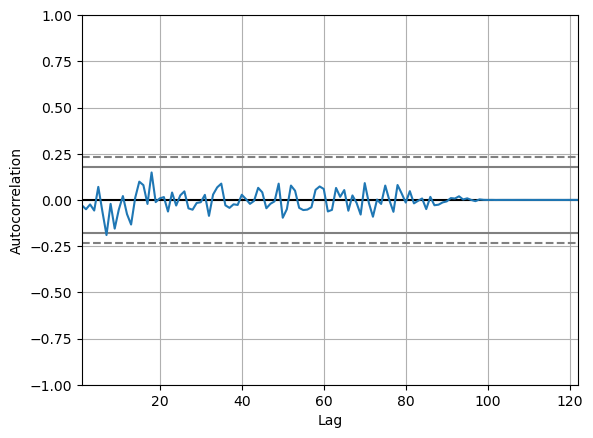

In [4]:
model = ARIMA(new_deaths, order=(4,4,4))  
fitted = model.fit()  
prediction=fitted.predict(start=0, end=len(new_deaths) , typ='levels')

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(new_deaths, label='training')
plt.plot(prediction, label='forecast')
plt.title('Forecast vs real data' )
plt.legend(loc='best', fontsize=8)
plt.show()

# set plot_verifs to True to plot the verifications
plot_verifs = True
if plot_verifs: 

    # we check that the residuals are white noise
    residuals = pd.DataFrame(fitted.resid)
    residuals.plot(title="Residuals")

    plt.show()
    residuals.plot(kind='kde', title='Density')
    plt.show()
    print(residuals.describe())
    # autocorrélation of the residuals
    from pandas.plotting import autocorrelation_plot
    autocorrelation_plot(residuals)
    plt.show()



In [7]:

# set optimize_arima to True to optimize the ARIMA model
optimize_arima = False
if optimize_arima:
    min = 1000
    pmin=0
    dmin=0
    qmin=0
    for p in range(7): 
        print(p)
        for d in range(7): 
            for q in range(7): 
                if not (p,d,q) == (0,1,0):
                    model = ARIMA(new_deaths, order=(p,d,q))  
                    try : 
                        fitted = model.fit()  
                        prediction=fitted.predict(start=1, end=len(new_deaths) , typ='levels')
                        error = np.mean(np.abs(prediction - new_deaths))
                        if error < min:
                            min = error
                            pmin=p
                            dmin=d
                            qmin=q
                            print('new combinaition')
                            print(p,d,q,min)
                    except np.linalg.LinAlgError as err : 
                        print(p,d,q)
                        print('---------------------------')
                        print('ERROR')
                        print('---------------------------')


# results of precedent optimization: 
p_opt=1
d_opt=0
q_opt=0


This cell shows how to train an ARIMA on the interval $ [ 0;  s] $, with $s$ the split parameter, after which we make predictions. 

The reach parameter correspond to the range of the prediction (7 days for a week-ahead prediction)

[[554.4841706  568.81752452]
 [546.61964876 564.37766624]
 [500.15776367 535.55148605]
 [445.71434669 502.59831688]
 [426.60801725 503.41807653]
 [376.33521052 482.37824319]
 [341.11354517 475.72159929]]


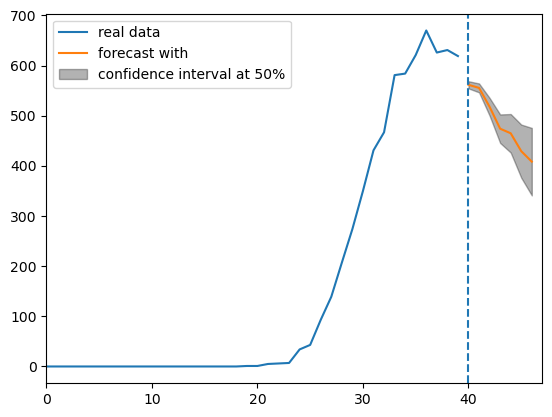

In [12]:
split=40
reach=7
al=0.5# (size of the prediction interval)
model = ARIMA(new_deaths[:split], order=(4,1,4))
fitted = model.fit()
predifore=fitted.get_forecast(reach).predicted_mean
predici=fitted.get_forecast(reach).conf_int(alpha=al)
print(predici)
# predici2=fitted.get_forecast(reach).conf_int(alpha=0.5)
# print(predici2)
ci_low=[elt[0] for elt in predici]
ci_high=[elt[1] for elt in predici]
plt.plot(new_deaths[:split], label='real data')
plt.plot([i for i in range(split, split + reach)] , predifore, label='forecast with')
plt.fill_between([i for i in range(split, split + reach)], ci_low, ci_high, color='black', alpha=.3, label='confidence interval at ' + str(round((1-al)*100)) + '%')
plt.legend()
plt.axvline(split, linestyle='--')
plt.xlim(0,split+reach)

plt.show()


c:\Users\grego\Miniconda3\envs\env_qcm\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


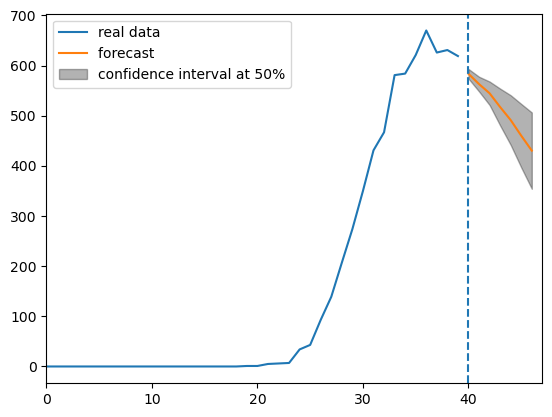

In [13]:
myarima=ARIMA_Model()
myarima.train(dates_of_pandemic, new_deaths[:40], grid_search=False)
# myarima.predict(reach, [0.5])
myarima.plot( reach, 0.5)

**Other ways to get confidence intervals that we will not use**: 


c:\Users\grego\Miniconda3\envs\env_qcm\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


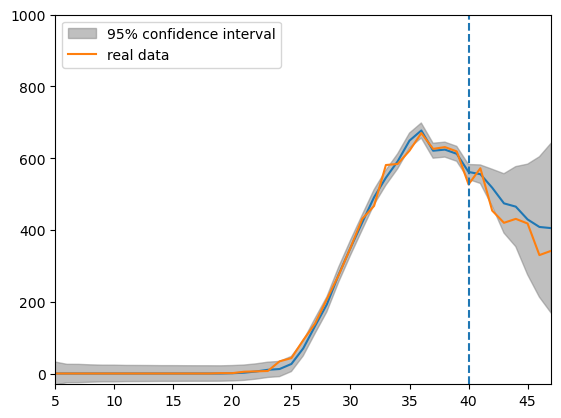

In [15]:
split=40
model = ARIMA(new_deaths[:split], order=(4,1,4))
fitted = model.fit()
prediction=fitted.predict(start=1, end=len(new_deaths)-1) # line to get access to the predictions
ci=fitted.conf_int()
# plot the confidence interval
c_low=ci[:,0]
c_high=ci[:,1]

plot_predict(fitted, start=0, end=split+7)
plt.plot(new_deaths, label='real data')
# plt.plot(prediction[:split+7], label='forecast')
plt.xlim(5,split+7)
plt.ylim(-30, 1000)
plt.axvline(split, linestyle='--')
plt.legend()
plt.show()

Different ways to get the predictions : 

c:\Users\grego\Miniconda3\envs\env_qcm\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


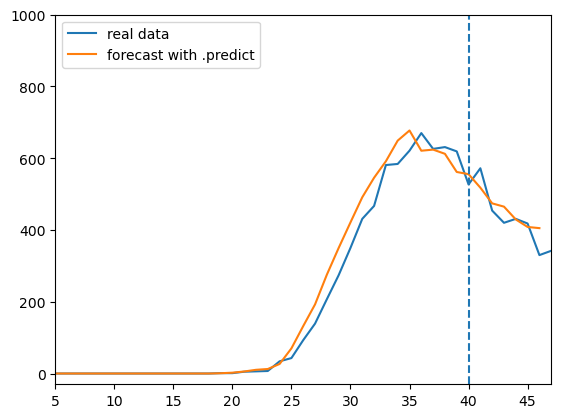

In [16]:
split=40
model = ARIMA(new_deaths[:split], order=(4,1,4))
fitted = model.fit()
prediction=fitted.predict(start=1, end=len(new_deaths)-1) # line to get access to the predictions



plt.plot(new_deaths, label='real data')
plt.plot(prediction[:split+7], label='forecast with .predict')
plt.xlim(5,split+7)
plt.ylim(-30, 1000)
plt.axvline(split, linestyle='--')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Deaths')
plt.title('Forecast of the number of deaths with ARIMA')
plt.show()

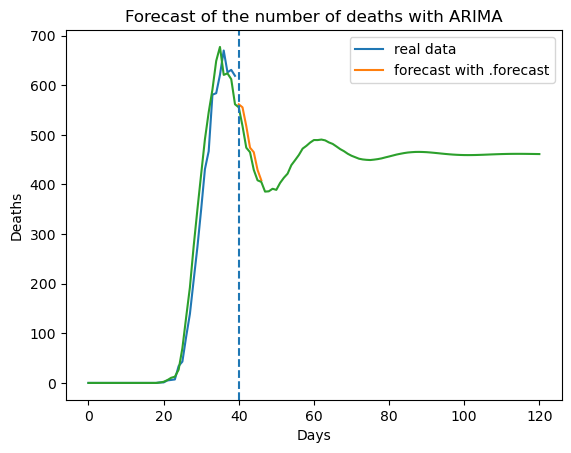

In [17]:
%matplotlib inline
plt.plot(new_deaths[:split], label='real data')
forecast=fitted.forecast(7)
plt.plot([i for i in range(split, split + 7)] , forecast, label='forecast with .forecast')
plt.plot(prediction)
plt.legend()
plt.axvline(split, linestyle='--')
plt.xlabel('Days')
plt.ylabel('Deaths')
plt.title('Forecast of the number of deaths with ARIMA')

plt.show()